# The Affect of Age and Hours Played on a Player's Subscription Status
**By: Tima Komarov (82239450), Carmen Wen (95556593), Pim-on Ingkanisorn(44803013), Omar Harb (57845414)**
<br>

In [36]:
library(tidyverse)
library(repr)
library(tidymodels)

# Introduction
The UBC Computer Science research group, led by Frank Wood, set up a MineCraft server to collect in-game data on player behaviours. The recorded data will be used in this study to explore factors that influence players' engagement, specifically focusing on which characteristics and behaviours predict a player's likelihood of subscribing to the game's newsletter. 

For this study, we aim to answer the broad question: "What player characteristics and behaviors are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?" More specifically, **can the number of hours played and the players age predict if a player subscribes to a game related newsletter in the players data set?** 

We would do this by using the `players.csv` dataset, which contains 7 variables (`experience`, `subscribe`, `hashedEmail`, `played_hours`, `name`, `gender`, `Age`) and 196 observations. However, for our analysis, only played_hours, and Age will be utilized to develop a predictive model using k-nearest neighbours for subscription likelihood.

| Variable Name  | Type        | Description |
|---------------|------------|-------------|
| played_hours| Numeric     | Total hours played |
| Age         | Numeric     | Player’s age (8 to 50 years) |
| subscribe   | logical     | subscription status (TRUE/FALSE) |
<p style="text-align: center; font-style:italic">Figure 1 - Variables used in the data analysis</p>

We hypothesis that a player's played_hours and Age be used as predictors of their subscription status.


# Methods

In this dataset, the subscription status must be converted to a factor variable during wrangling, while Age and played hours stay as numeric variables. Then we must ensure that all NA values are removed before creating a KNN classification model. The `players` dataset initial has 196 observations, but then has 194 observations after the NA values are removed.

- why 80-20 train-test
- Why V=5 in folds

In [37]:
players <- read_csv("https://raw.githubusercontent.com/crmnwn06/minecraft-data/refs/heads/main/players.csv" )

clean_player <- players |> 
    select(subscribe, played_hours,Age) |>
    mutate(subscribe=as_factor(subscribe)) |>
    na.omit()

head(clean_player)

nrow(clean_player)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


subscribe,played_hours,Age
<fct>,<dbl>,<dbl>
TRUE,30.3,9
TRUE,3.8,17
FALSE,0.0,17
TRUE,0.7,21
TRUE,0.1,21
TRUE,0.0,17


[1] 194

*Figure 2 - Clean dataset with the `subscribe`, `played_hours`, and `Age` variables*

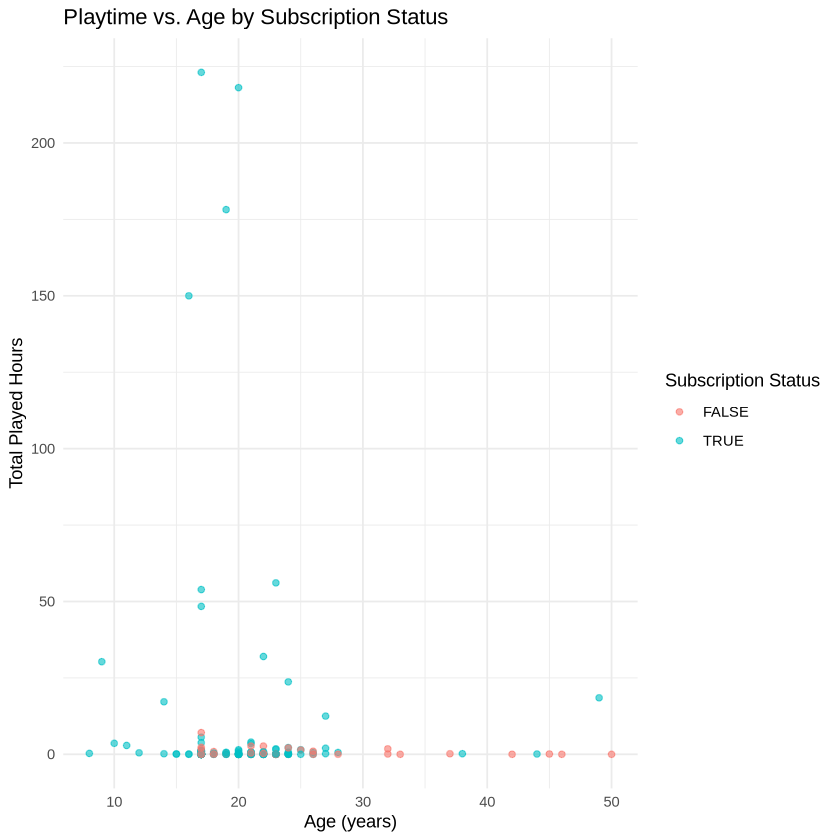

In [38]:
#Visualization of data: Scatter Plot of Playtime vs. Age (Colored by Subscription Status)
ggplot(clean_player, aes(x = Age, y = played_hours, color = as.factor(subscribe))) +
  geom_point(alpha = 0.6) +
  labs(
    title = "Playtime vs. Age by Subscription Status",
    x = "Age (years)",
    y = "Total Played Hours",
    color = "Subscription Status"
  ) +
  theme_minimal()

*Figure 3 - Scatter Plot of Playtime vs. Age (Coloured by Subscription Status)*

The above scatter plot visualizes the brief relationship between playtime and age with subscription to give us an idea of how to approach the study. This graph reveals that most of the players (bulk) are under the age of 30. Subscription players are more common among people with higher play hours and younger ages, while non-subscribed players are common among players with lower play hours and players with older ages. This visualization shows that these 2 factors have the potential to be the predictors for subscription status. 

Before classification, we must determine the balance of subscriptions status to later determine whether our algorithm is better at predicting than random guessing. 

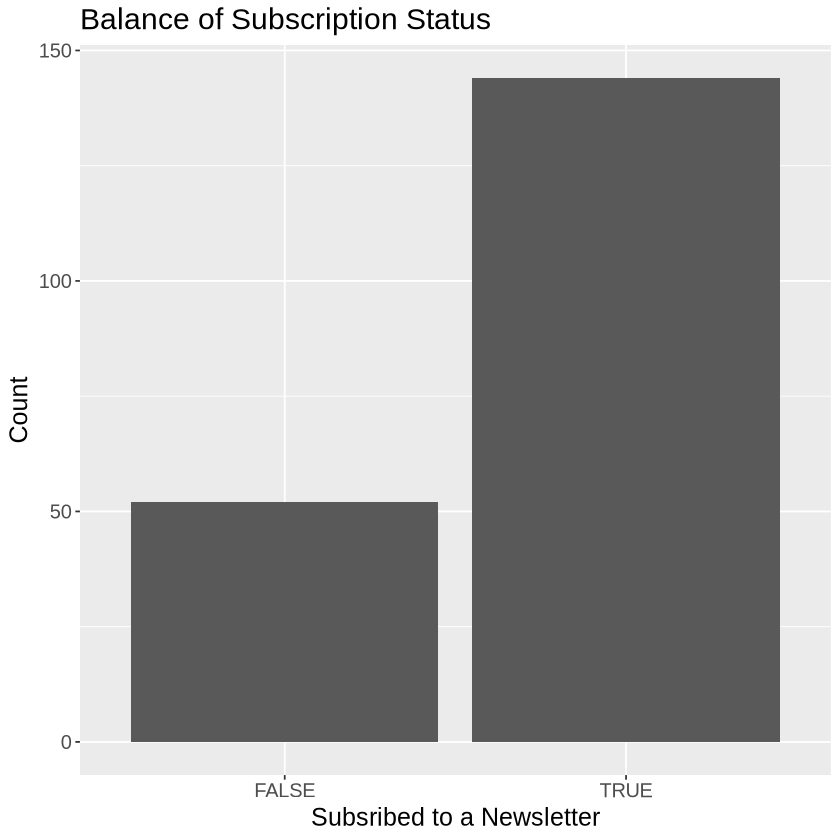

In [39]:
#balance of subscription status
ggplot(players, aes(x = subscribe)) +
    geom_bar() +
    labs(x = 'Subsribed to a Newsletter',
         y = 'Count',
         title = 'Balance of Subscription Status') +
    theme(text = element_text(size = 15))

*Figure 4 - Balance of Subsription Status*

We can tell that there is an obvious imbalance between the number of falses and trues. This means that we need to calculate the random accuracy using the accuracy formula. 

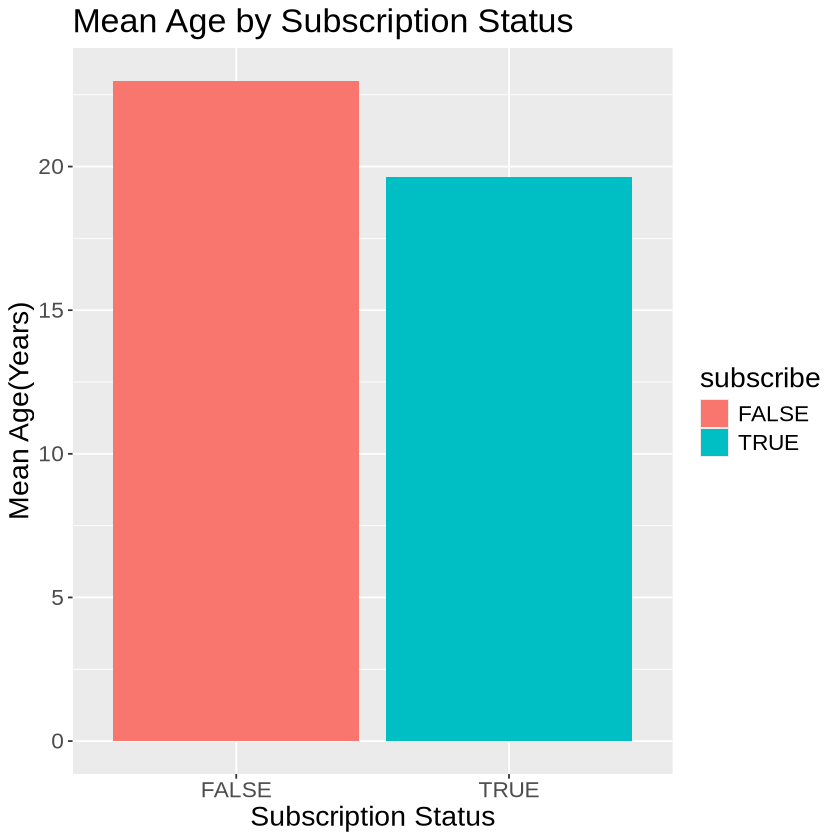

In [40]:
means <- clean_player |>
  group_by(subscribe) |>
  summarise(mean_age = mean(Age),
            mean_hours = mean(played_hours))

age_plot <- means|>
            ggplot(aes(x = subscribe, y = mean_age, fill=subscribe)) +
              geom_bar(stat="identity") +
              labs(title = "Mean Age by Subscription Status",
               x = "Subscription Status",
               y = "Mean Age(Years)") +
            theme(text=element_text(size=17))
age_plot

*Figure 5 - A bar plot of Mean Ages vs Subscription status*

Non-subscibed players have slightly higher mean age compared to the subscribed ones. This indicates that age plays a factor in determining of a player subscribes to a game-related newsletter, which relates to our question.

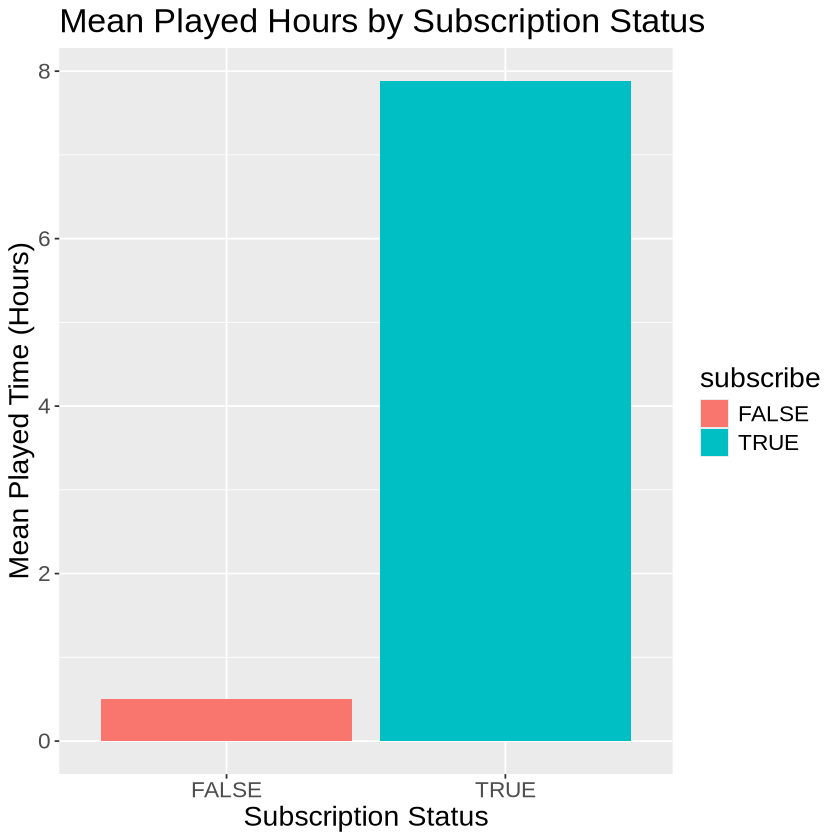

In [41]:
played_hours_plot <- means|>
            ggplot(aes(x = subscribe, y = mean_hours, fill=subscribe)) +
            geom_bar(stat = "identity") +
            labs(title = "Mean Played Hours by Subscription Status",
            x = "Subscription Status",
            y = "Mean Played Time (Hours)") +
            theme(text=element_text(size=17))

played_hours_plot

*Figure 6 - A bar graph of played time vs subscription status*

Players who are subscribed have significantly higher playtime compared to non-subscribers, so playtime could influence if a player subscribes to a game-related newsletter, which is relavent to our question.

Figures 5 and 6 demonstrate that play time has a stronger relationship with subscription status than age does. To avoid biased model performance, these 2 factors should be scaled before being used in the prediction model. This will allow both predictors to contribute equally.

In [42]:
# Given class counts
true_count <- 142
false_count <- 52
total_count <- true_count + false_count

# Calculate probabilities
p_true <- true_count / total_count
p_false <- false_count / total_count

# Random guessing accuracy formula
random_accuracy <- (p_true^2) + (p_false^2)

random_accuracy

[1] 0.6076097

The random accuracy is found to be 60.8%. This will be then used to compare with our model accuracy to see the performance of the model we made.

Here, the data is split into the training set (`player_train`) and the testing set (`player_test`). We choose to use 80% of the initial data as the training set and 20% as the testing set, as per general statistical practice.

In [43]:
set.seed(2025) 
player_split <- initial_split(clean_player, prop = 0.8, strata = subscribe)
player_train <- training(player_split)
player_test <- testing(player_split)

A classifcation model is specified. The recipe labels the `subscribe` variable as the response variable, and the `played_hours` and `Age` variable as the predictor variables. The intention is to find the best K-value to maximize accuracy for our final classification model.

In [44]:
spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

recipe <- recipe(subscribe ~ ., data = player_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

k_vals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

player_fold <- vfold_cv(player_train, v = 5, strata = subscribe)

knn_results <- workflow() |>
  add_recipe(recipe) |>
  add_model(spec) |>
  tune_grid(resamples = player_fold, grid = k_vals) |>
  collect_metrics()

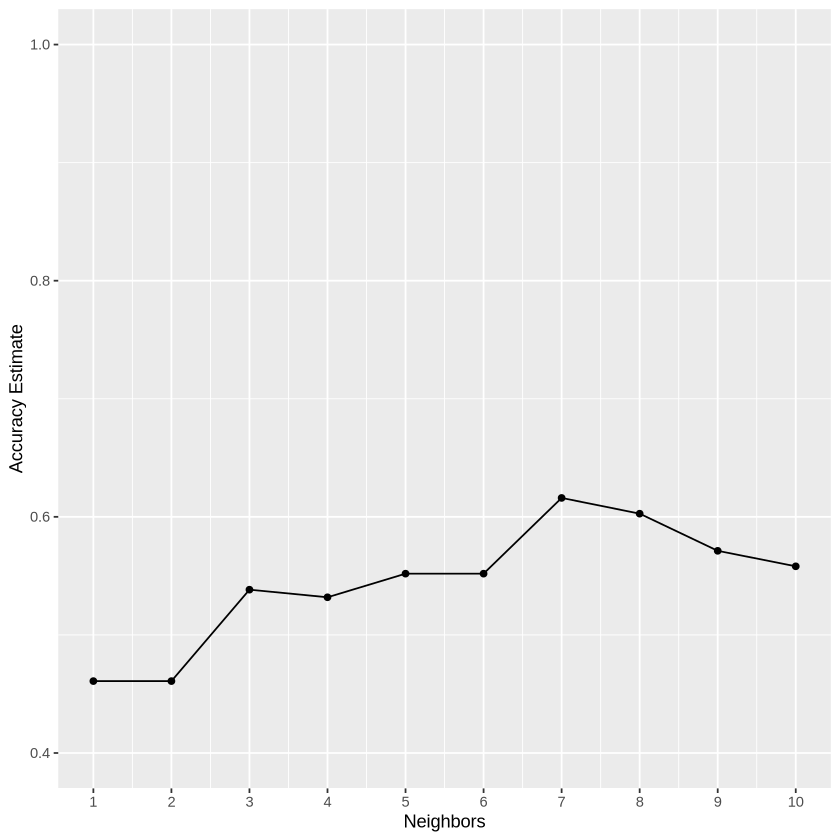

In [45]:
#accuracies and visualizing best k value
accuracies <- knn_results |>
  filter(.metric == "accuracy")

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       scale_x_continuous(breaks = seq(0, 10, by = 1)) +  # adjusting the x-axis
       scale_y_continuous(limits = c(0.4, 1.0)) # adjusting the y-axis
accuracy_versus_k


*Figure 7 - Line plot of accuracy versus k to find the best k-value*

A k-value of 7 was chosen since it has the highest accuracy. In our model, we used 7 neighbours (k = 7) to predict the subscription status. This k was used because of the small size of this dataset (194 observations after dropping NA values); the limit range of k was then limited to 1 to 10. Using large k with such a small dataset would likely lead to an underfitting model, although we previously found that k = 19 yields the highest accuracy from a similar model to figure 7 that we modelled. In order to improve the model performance and allow for more optimal k, we would need a bigger dataset to reduce the risk of an underfitting model.
  

In [46]:
#This code determines the best k value
best_k <- accuracies |>
        arrange(desc(mean)) |>
        head(1) |>
        pull(neighbors)
best_k

[1] 7

From the graph and code we can tell that 7 neighbors provides the best accuracy estimation. 

In [47]:
#resampling
resample_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
  set_engine("kknn") |>
  set_mode("classification")

resample_tune

recipe2 <- recipe(subscribe ~ ., data = player_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

recipe2

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = best_k
  weight_func = rectangular

Computational engine: kknn 




── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 2



── Operations 

• Scaling for: all_predictors()

• Centering for: all_predictors()



In [48]:
resample_fit <- workflow() |>
  add_recipe(recipe2) |>
  add_model(resample_tune) |>
  fit(data = player_train)

resample_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(7,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.3831169
Best kernel: rectangular
Best k: 7

In [49]:
#metrics 
player_predict <- predict(resample_fit, player_test) |>
  bind_cols(player_test)

player_predict |>
  metrics(truth = subscribe, estimate = .pred_class) |>
  filter(.metric == "accuracy")

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.675


*Figure 8 - Accuracy of the model*

This shows that our prediction model yields 67.5% accuracy.

# Results 
Using k=7, we found an accuracy of 0.675 or 67.5%. Which is 7% better then randomly guessing whether an individual is subscribed to the newsletter or not.

# Conclusion
From the results, we conclude that the model correctly classifies 67.5% of the instances. Given that random guessing accuracy is ~61%, we can say that the KNN model is better at predicting a person's subscription status based on age and total played hours. With the smaller dataset we ran into the issue of having a K which wasn’t a large portion of our data set.

# Discussion

Playtime and age has been found to be indicative of subscription status to a game-related newsletter. These two factors can predict whether a player is subcribed with an accuracy of 67.5%. Overall, our findings indicate the using play time and age as predictors yielded better odds of predicating subscription status as opposed to randomly guessing. Based on the exploratory bar plots shown above, this is what we expected to find, and our hypothesis is satisfied. These findings are impactful because advertisements could be targeted towards this category of players. For example, knowing that mostly twenty-year-olds read these news letters, the written language and style could be catered towards that age group. Or, when a player reaches eight hours of gameplay, a notification could pop up encouraging a player to subscribe to a game related newsletter. A future exploratory question could investigate the correlation between age and played hours. Annother predictive question that arises from this study could be estimating the age of a player based on their played hours and subscription status.

# References
Tiffany Timbers, Trevor Campbell. “Data Science.” Chapter 1 R and the Tidyverse, 21 Aug. 2024, datasciencebook.ca/intro.html. Accessed 05 Apr. 2025. 

Wood, Frank. *Minecraft Player and Session Dataset*. Collected by the UBC Computer Science Research Group. Provided in DSCI 100 course materials, 2025. Unpublished dataset.